# Solutions 1 - Examples in Julia



## Assignment 1

The function `eps()` return the smallest real number larger than 1.0. It can be called for each of the `AbstractFloat` types. 

Functions `realmin()` and `realmax()` return the largest and the smallest positive numbers representable in the given type.

In [1]:
?eps

search: eps @elapsed indexpids expanduser escape_string setprecision peakflops



```
eps(::Type{T}) where T<:AbstractFloat
eps()
```

Returns the *machine epsilon* of the floating point type `T` (`T = Float64` by default). This is defined as the gap between 1 and the next largest value representable by `T`, and is equivalent to `eps(one(T))`.

```jldoctest
julia> eps()
2.220446049250313e-16

julia> eps(Float32)
1.1920929f-7

julia> 1.0 + eps()
1.0000000000000002

julia> 1.0 + eps()/2
1.0
```

```
eps(x::AbstractFloat)
```

Returns the *unit in last place* (ulp) of `x`. This is the distance between consecutive representable floating point values at `x`. In most cases, if the distance on either side of `x` is different, then the larger of the two is taken, that is

```
eps(x) == max(x-prevfloat(x), nextfloat(x)-x)
```

The exceptions to this rule are the smallest and largest finite values (e.g. `nextfloat(-Inf)` and `prevfloat(Inf)` for [`Float64`](@ref)), which round to the smaller of the values.

The rationale for this behavior is that `eps` bounds the floating point rounding error. Under the default `RoundNearest` rounding mode, if $y$ is a real number and $x$ is the nearest floating point number to $y$, then

$$
|y-x| \leq \operatorname{eps}(x)/2.
$$

```jldoctest
julia> eps(1.0)
2.220446049250313e-16

julia> eps(prevfloat(2.0))
2.220446049250313e-16

julia> eps(2.0)
4.440892098500626e-16

julia> x = prevfloat(Inf)      # largest finite Float64
1.7976931348623157e308

julia> x + eps(x)/2            # rounds up
Inf

julia> x + prevfloat(eps(x)/2) # rounds down
1.7976931348623157e308
```

```
eps(::DateTime) -> Millisecond
eps(::Date) -> Day
eps(::Time) -> Nanosecond
```

Returns `Millisecond(1)` for `DateTime` values, `Day(1)` for `Date` values, and `Nanosecond(1)` for `Time` values.


In [2]:
?realmax

search: realmax realmin readdlm ReadOnlyMemoryError



```
realmax(T)
```

The highest finite value representable by the given floating-point DataType `T`.

# Examples

```jldoctest
julia> realmax(Float16)
Float16(6.55e4)

julia> realmax(Float32)
3.4028235f38
```


In [3]:
subtypes(AbstractFloat)

4-element Array{Union{DataType, UnionAll},1}:
 BigFloat
 Float16 
 Float32 
 Float64 

In [4]:
# Default values are for Float64
eps(), realmax(), realmin()

(2.220446049250313e-16, 1.7976931348623157e308, 2.2250738585072014e-308)

In [5]:
T=Float32
eps(T), realmax(T), realmin(Float32)

(1.1920929f-7, 3.4028235f38, 1.1754944f-38)

In [6]:
T=BigFloat
eps(T), realmax(T), realmin(T), map(Int64,round(log10(1/eps(T))*log(10)/log(2)))

(1.727233711018888925077270372560079914223200072887256277004740694033718360632485e-77, 5.875653789111587590936911998878442589938516392745498308333779606469323584389875e+1388255822130839282, 8.50969131174083613912978790962048280567755996982969624908264897850135431080301e-1388255822130839284, 255)

We see that `BigFloat` has approximately 77 significant decimal digits (actually 256 bits) and very large exponents. This makes the format ideal for Greaffe's method. 

Precision of `BigFloat` can be increased, but exponents do not change.

In [7]:
precision(BigFloat)

256

In [8]:
setprecision(512)
eps(T), realmax(T)

(1.49166814624004134865819306309258676747529430692008137885430366664125567701402366098723497808008556067230232065116722029068254561904506053209723296591841694e-154, 5.8756537891115875909369119988784425899385163927454983083337796064693235843899260221253999241262860478325497273605710644114525396031501137889011407098680862e+1388255822130839282)

In [9]:
setprecision(256)

256

Here is the function for the Graeffe's method. We also define small test polynomial with all real simple zeros.

In [10]:
using Polynomials
p=poly([1,2,3,4])

Poly(24 - 50*x + 35*x^2 - 10*x^3 + x^4)

In [11]:
roots(p)

4-element Array{Float64,1}:
 4.0
 3.0
 2.0
 1.0

In [12]:
function Graeffe{T}(p::Poly{T},steps::Int64)
    # map the polynomial to BigFloat
    pbig=Poly(map(BigFloat,coeffs(p)))
    px=Poly([zero(BigFloat),one(BigFloat)])
    n=degree(p)
    σ=map(BigFloat,2^steps)
    for k=1:steps
        peven=Poly(coeffs(pbig)[1:2:end])
        podd=Poly(coeffs(pbig)[2:2:end])
        pbig=peven^2-podd^2*px 
    end
    # @show p[end]
    y=Array{BigFloat}(n)
    # Normalize if p is not monic
    y[1]=-pbig[end-1]/pbig[end]
    for k=2:n
        y[k]=-pbig[end-k]/pbig[end-(k-1)]
    end
    # Extract the roots
    for k=1:n
        y[k]=exp(log(y[k])/σ)
    end
    # Return root in Float64
    map(Float64,y)
end

Graeffe (generic function with 1 method)

In [13]:
Graeffe(p,8)

4-element Array{Float64,1}:
 4.0
 3.0
 2.0
 1.0

Now the Wilkinson's polynomial:

In [14]:
ω=poly(collect(one(BigFloat):20))

Poly(2.432902008176640000000000000000000000000000000000000000000000000000000000000000e+18 - 8.752948036761600000000000000000000000000000000000000000000000000000000000000000e+18*x + 1.380375975364070400000000000000000000000000000000000000000000000000000000000000e+19*x^2 - 1.287093124515098880000000000000000000000000000000000000000000000000000000000000e+19*x^3 + 8.037811822645051776000000000000000000000000000000000000000000000000000000000000e+18*x^4 - 3.599979517947607200000000000000000000000000000000000000000000000000000000000000e+18*x^5 + 1.206647803780373360000000000000000000000000000000000000000000000000000000000000e+18*x^6 - 3.113336431613906400000000000000000000000000000000000000000000000000000000000000e+17*x^7 + 6.303081209929489600000000000000000000000000000000000000000000000000000000000000e+16*x^8 - 1.014229986551145000000000000000000000000000000000000000000000000000000000000000e+16*x^9 + 1.307535010540395000000000000000000000000000000000000000000000000000000000000000e+15*x^10 - 1.355851828995300000000000000000000000000000000000000000000000000000000000000000e+14*x^11 + 1.131027699538100000000000000000000000000000000000000000000000000000000000000000e+13*x^12 - 7.561111845000000000000000000000000000000000000000000000000000000000000000000000e+11*x^13 + 4.017177163000000000000000000000000000000000000000000000000000000000000000000000e+10*x^14 - 1.672280820000000000000000000000000000000000000000000000000000000000000000000000e+09*x^15 + 5.332794600000000000000000000000000000000000000000000000000000000000000000000000e+07*x^16 - 1.256850000000000000000000000000000000000000000000000000000000000000000000000000e+06*x^17 + 2.061500000000000000000000000000000000000000000000000000000000000000000000000000e+04*x^18 - 2.100000000000000000000000000000000000000000000000000000000000000000000000000000e+02*x^19 + 1.000000000000000000000000000000000000000000000000000000000000000000000000000000*x^20)

In [15]:
Graeffe(ω,8)

20-element Array{Float64,1}:
 20.0
 19.0
 18.0
 17.0
 16.0
 15.0
 14.0
 13.0
 12.0
 11.0
 10.0
  9.0
  8.0
  7.0
  6.0
  5.0
  4.0
  3.0
  2.0
  1.0

In [16]:
ans[2]

18.999999925187158

In [17]:
Graeffe(ω,16)

20-element Array{Float64,1}:
 20.0
 19.0
 18.0
 17.0
 16.0
 15.0
 14.0
 13.0
 12.0
 11.0
 10.0
  9.0
  8.0
  7.0
  6.0
  5.0
  4.0
  3.0
  2.0
  1.0

In [18]:
ans[2]

19.0

We now generate the Chebyshev polynomial $T_{50}(x)$ using the three term recurence.

In [19]:
n=50
T0=Poly([BigInt(1)])
T1=Poly([0,1])
Tx=Poly([0,1])
for i=3:n+1
    T=2*Tx*T1-T0
    T0=T1
    T1=T
end

In [20]:
T

Poly(-1 + 1250*x^2 - 260000*x^4 + 21528000*x^6 - 947232000*x^8 + 25638412800*x^10 - 466152960000*x^12 + 6034375680000*x^14 - 57930006528000*x^16 + 424820047872000*x^18 - 2432653747814400*x^20 + 11057517035520000*x^22 - 40383975260160000*x^24 + 119536566770073600*x^26 - 288405684905574400*x^28 + 568855350917201920*x^30 - 917508630511616000*x^32 + 1206989963132928000*x^34 - 1287455960675123200*x^36 + 1102487181118668800*x^38 - 746299014911098880*x^40 + 390051749953536000*x^42 - 151732604633088000*x^44 + 41341637204377600*x^46 - 7036874417766400*x^48 + 562949953421312*x^50)

In [21]:
using Gadfly

In [22]:
f(x)=T(x)

f (generic function with 1 method)

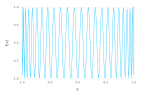

In [23]:
Gadfly.plot(f,-1,1)

In order to use Graeffe's method, we need to shift $T$ to the right by one, so that all roots have simple moduli, that is, we compute $T(1-x)$:

In [24]:
Ts=T(Poly([BigFloat(1),-1]));

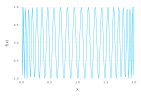

In [25]:
fs(x)=Ts(x)
Gadfly.plot(fs,0,2)

In [26]:
# Computed roots, 16 steps are fine
y=Graeffe(Ts,16)-1

50-element Array{Float64,1}:
  0.999507
  0.995562
  0.987688
  0.975917
  0.960294
  0.940881
  0.917755
  0.891007
  0.860742
  0.827081
  0.790155
  0.750111
  0.707107
  ⋮       
 -0.750111
 -0.790155
 -0.827081
 -0.860742
 -0.891007
 -0.917755
 -0.940881
 -0.960294
 -0.975917
 -0.987688
 -0.995562
 -0.999507

In [27]:
# Exact roots
z=map(Float64,[cos((2*k-1)*pi/(2*n)) for k=1:n]);

In [28]:
# Relative error
maximum(abs,(z-y)./z)

3.313622835402366e-15

## Assignment 2

The key is that `/` works for block matrices, too. $A$ is overwritten and must therefore be copied at the beggining of the function, so that the original matrix is not overwritten.

In [29]:
function mylu{T}(A1::Array{T}) # Strang, page 100
    A=copy(A1)
    n,m=size(A)
    for k=1:n-1
        for rho=k+1:n
            A[rho,k]=A[rho,k]/A[k,k]
            for l=k+1:n
                A[rho,l]=A[rho,l]-A[rho,k]*A[k,l]
            end
        end
    end
    # We return L and U
    L=tril(A,-1)
    U=triu(A)
    # This is the only difference for the block case
    for i=1:maximum(size(L))
        L[i,i]=one(L[1,1])
    end
    L,U
end

mylu (generic function with 1 method)

In [30]:
A=rand(5,5)

5×5 Array{Float64,2}:
 0.749509  0.957791  0.959447   0.184119  0.548922
 0.327809  0.997     0.688513   0.540158  0.128413
 0.632706  0.415986  0.0262183  0.151807  0.261743
 0.116657  0.227226  0.619214   0.574788  0.118238
 0.859223  0.459163  0.89354    0.145631  0.793975

In [31]:
L,U=mylu(A)

([1.0 0.0 … 0.0 0.0; 0.437364 1.0 … 0.0 0.0; … ; 0.155644 0.135189 … 1.0 0.0; 1.14638 -1.10506 … 0.692266 1.0], [0.749509 0.957791 … 0.184119 0.548922; 0.0 0.578096 … 0.459631 -0.111666; … ; 0.0 0.0 … 0.706471 -0.152205; 0.0 0.0 … 0.0 0.10477])

In [32]:
L*U-A

5×5 Array{Float64,2}:
 0.0  0.0  0.0   0.0           0.0        
 0.0  0.0  0.0   0.0           0.0        
 0.0  0.0  0.0  -2.77556e-17   0.0        
 0.0  0.0  0.0   0.0          -2.77556e-17
 0.0  0.0  0.0   0.0           0.0        

In [33]:
L

5×5 Array{Float64,2}:
 1.0        0.0        0.0       0.0       0.0
 0.437364   1.0        0.0       0.0       0.0
 0.844161  -0.679029   1.0       0.0       0.0
 0.155644   0.135189  -0.721196  1.0       0.0
 1.14638   -1.10506   -0.151019  0.692266  1.0

In [34]:
U

5×5 Array{Float64,2}:
 0.749509  0.957791   0.959447  0.184119   0.548922
 0.0       0.578096   0.268885  0.459631  -0.111666
 0.0       0.0       -0.601129  0.308483  -0.27746 
 0.0       0.0        0.0       0.706471  -0.152205
 0.0       0.0        0.0       0.0        0.10477 

We now try block-matrices. First, a small example:

In [35]:
# Try k,l=32,16 i k,l=64,8
k,l=2,4
Ab=[rand(k,k) for i=1:l, j=1:l]

4×4 Array{Array{Float64,2},2}:
 [0.312029 0.41026; 0.0696754 0.828377]  …  [0.0683545 0.949278; 0.653417 0.395269]
 [0.70918 0.297424; 0.304522 0.864542]      [0.499324 0.225109; 0.564402 0.101376] 
 [0.509229 0.711392; 0.176943 0.680999]     [0.408986 0.414309; 0.100587 0.442306] 
 [0.136995 0.805759; 0.854714 0.754634]     [0.383241 0.407862; 0.227408 0.298089] 

In [36]:
Ab[1,1]

2×2 Array{Float64,2}:
 0.312029   0.41026 
 0.0696754  0.828377

In [37]:
L,U=mylu(Ab)

(Array{Float64,2}[[1.0 0.0; 0.0 1.0] [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0]; [2.46526 -0.861892; 0.835267 0.629985] [1.0 0.0; 0.0 1.0] [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0]; [1.61931 0.0568043; 0.431188 0.608539] [0.595898 -0.403463; -0.121985 0.0433826] [1.0 0.0; 0.0 1.0] [0.0 0.0; 0.0 0.0]; [0.24943 0.849164; 2.85109 -0.501045] [-0.601638 -0.398448; 1.17239 1.20473] [1.32125 1.55607; -1.91485 1.48135] [1.0 0.0; 0.0 1.0]], Array{Float64,2}[[0.312029 0.41026; 0.0696754 0.828377] [0.737648 0.654432; 0.00811802 0.100021] [0.414621 0.235837; 0.896281 0.132905] [0.0683545 0.949278; 0.653417 0.395269]; [0.0 0.0; 0.0 0.0] [-1.23404 -0.716213; 0.202833 -0.517986] [0.214243 -0.446145; -0.61066 -0.0334945] [0.893988 -1.77443; 0.0956641 -0.940538]; [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0] [-0.365378 -0.0237199; -0.189956 0.369117] [-0.232946 -0.467413; -0.221613 -0.383199]; [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0] [1.03993 -0.393028; -0.921213 0.675702]])

In [38]:
L[1,1]

2×2 Array{Float64,2}:
 1.0  0.0
 0.0  1.0

In [39]:
# Residual
R=L*U-Ab

4×4 Array{Array{Float64,2},2}:
 [0.0 0.0; 0.0 0.0]                  …  [0.0 0.0; 0.0 0.0]                 
 [2.22045e-16 1.11022e-16; 0.0 0.0]     [0.0 0.0; 0.0 0.0]                 
 [0.0 0.0; 0.0 0.0]                     [-5.55112e-17 0.0; 0.0 0.0]        
 [-1.11022e-16 0.0; 0.0 0.0]            [0.0 -2.22045e-16; 2.22045e-16 0.0]

In [40]:
norm(R) # This is not defined

LoadError: [91mMethodError: no method matching zero(::Type{Array{Float64,2}})[0m
Closest candidates are:
  zero([91m::Type{Base.LibGit2.GitHash}[39m) at libgit2/oid.jl:106
  zero([91m::Type{Base.Pkg.Resolve.VersionWeights.VWPreBuildItem}[39m) at pkg/resolve/versionweight.jl:82
  zero([91m::Type{Base.Pkg.Resolve.VersionWeights.VWPreBuild}[39m) at pkg/resolve/versionweight.jl:124
  ...[39m

In [41]:
vecnorm(R)

3.764949453935611e-16

We need a convenience function to unblock the block-matrix:

In [42]:
unblock(A) = mapreduce(identity, hcat, 
    [mapreduce(identity, vcat, A[:,i]) for i = 1:size(A,2)])

unblock (generic function with 1 method)

In [43]:
unblock(Ab)

8×8 Array{Float64,2}:
 0.312029   0.41026   0.737648    …  0.235837   0.0683545  0.949278
 0.0696754  0.828377  0.00811802     0.132905   0.653417   0.395269
 0.70918    0.297424  0.57746        0.0207058  0.499324   0.225109
 0.304522   0.864542  0.82408        0.247221   0.564402   0.101376
 0.509229   0.711392  0.377745       0.11338    0.408986   0.414309
 0.176943   0.680999  0.482339    …  0.604655   0.100587   0.442306
 0.136995   0.805759  0.852508       0.996477   0.383241   0.407862
 0.854714   0.754634  0.896619       0.634605   0.227408   0.298089

In [44]:
norm(unblock(L*U-Ab))

3.0529221137268796e-16

We now compute timings and errors for bigger example:

In [45]:
# This is 512x512 matrix consisting of 16x16 blocks of dimension 32x32
k,l=32,16
Ab=[rand(k,k) for i=1:l, j=1:l]
# Unblocked version
A=unblock(Ab);

In [46]:
?lu

search: lu lufact lufact! flush ClusterManager values include include_string



```
lu(A, pivot=Val{true}) -> L, U, p
```

Compute the LU factorization of `A`, such that `A[p,:] = L*U`. By default, pivoting is used. This can be overridden by passing `Val{false}` for the second argument.

See also [`lufact`](@ref).

# Example

```jldoctest
julia> A = [4. 3.; 6. 3.]
2×2 Array{Float64,2}:
 4.0  3.0
 6.0  3.0

julia> L, U, p = lu(A)
([1.0 0.0; 0.666667 1.0], [6.0 3.0; 0.0 1.0], [2, 1])

julia> A[p, :] == L * U
true
```


In [48]:
# Built-in LAPACK function with pivoting 
@time L,U,p=lu(A);

  0.028569 seconds (24 allocations: 6.009 MiB)


In [49]:
norm(L*U-A[p,:])

3.1724054919219783e-14

In [50]:
# mylu() unblocked
@time L,U=mylu(A);

  1.248254 seconds (17 allocations: 6.001 MiB)


In [51]:
norm(L*U-A)

5.4324771150263447e-11

In [53]:
# mylu() on a block-matrix - much faster, but NO pivoting
@time L,U=mylu(Ab);

  0.080768 seconds (3.96 k allocations: 26.660 MiB, 16.38% gc time)


In [54]:
norm(unblock(L*U-Ab))

1.0153226642381016e-11

## Assignment 3

In [55]:
using Winston

In [56]:
k=20
n=20
E=Array{Any}(n,k)
# Unsymmetrix random uniform distribution
for i=1:k
    A=rand(n,n)
    E[:,i]=eigvals(A)
end
# We need this since plot cannot handle `Any`
E=map(eltype(E[1,1]),E)

20×20 Array{Complex{Float64},2}:
    10.0929+0.0im             9.8114+0.0im        …    9.69671+0.0im     
   0.816613+1.13108im       -1.13801+0.100756im       -1.23818+0.76059im 
   0.816613-1.13108im       -1.13801-0.100756im       -1.23818-0.76059im 
   0.475683+1.13754im      -0.856213+0.581185im        1.27218+0.0im     
   0.475683-1.13754im      -0.856213-0.581185im        1.14319+0.0im     
  -0.145603+1.09112im       0.380656+1.06703im    …   0.265608+1.05983im 
  -0.145603-1.09112im       0.380656-1.06703im        0.265608-1.05983im 
    1.18809+0.0im        -0.00498525+1.02911im        0.620669+0.784127im
   0.132453+0.764737im   -0.00498525-1.02911im        0.620669-0.784127im
   0.132453-0.764737im       1.15527+0.0im            -1.05856+0.0im     
  -0.630969+0.549251im       1.00224+0.0im        …   0.141715+0.715558im
  -0.630969-0.549251im      0.574807+0.732449im       0.141715-0.715558im
   -1.02418+0.0im           0.574807-0.732449im        0.44835+0.48662im 
  -0.

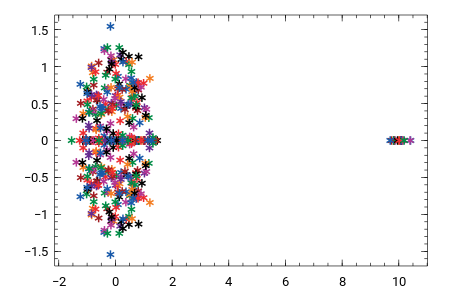

In [57]:
Winston.plot(E,"*")

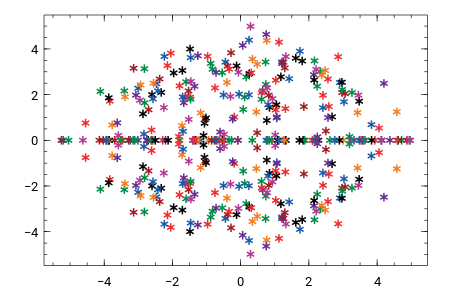

In [58]:
# Unsymmetric random normal distribution
E=Array{Any}(n,k)
for i=1:k
    A=randn(n,n)
    E[:,i]=eigvals(A)
end
# We need this for plot to work
E=map(eltype(E[1,1]),E)
Winston.plot(E,"*")

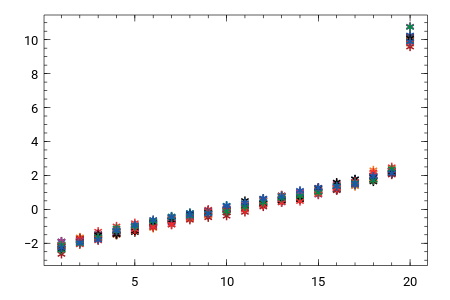

In [59]:
# Symmetric random uniform distribution
E=Array{Any}(n,k)
for i=1:k
    A=rand(n,n)
    A=triu(A)+triu(A,1)'
    E[:,i]=eigvals(A)
end
# We need this for plot to work
E=map(eltype(E[1,1]),E)
Winston.plot(E,"*")

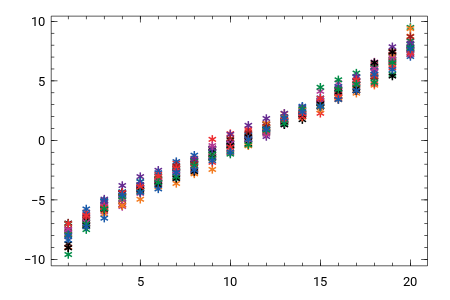

In [60]:
# Symmetric random normal distribution
E=Array{Any}(n,k)
for i=1:k
    A=randn(n,n)
    A=triu(A)+triu(A,1)'
    E[:,i]=eigvals(A)
end
# We need this for plot to work
E=map(eltype(E[1,1]),E)
Winston.plot(E,"*")

In [61]:
# Now the interactive partcxx
using Interact

INFO: Interact.jl: using new nbwidgetsextension protocol


Interact.Options{:SelectionSlider,Int64}(1: "input" = 20 Int64 , "k", 20, "20", 11, Interact.OptionDict(DataStructures.OrderedDict("10"=>10,"11"=>11,"12"=>12,"13"=>13,"14"=>14,"15"=>15,"16"=>16,"17"=>17,"18"=>18,"19"=>19…), Dict(30=>"30",16=>"16",11=>"11",21=>"21",26=>"26",25=>"25",10=>"10",29=>"29",19=>"19",17=>"17"…)), Any[], Any[], true, "horizontal", true)

Interact.Options{:SelectionSlider,Int64}(3: "input-2" = 20 Int64 , "n", 20, "20", 11, Interact.OptionDict(DataStructures.OrderedDict("10"=>10,"11"=>11,"12"=>12,"13"=>13,"14"=>14,"15"=>15,"16"=>16,"17"=>17,"18"=>18,"19"=>19…), Dict(30=>"30",16=>"16",11=>"11",21=>"21",26=>"26",25=>"25",10=>"10",29=>"29",19=>"19",17=>"17"…)), Any[], Any[], true, "horizontal", true)

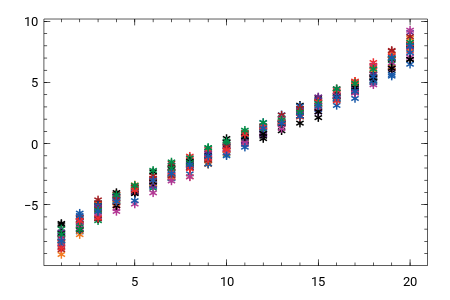

In [62]:
@manipulate for k=10:30, n=10:30
    E=Array{Any}(n,k)
    for i=1:k
        A=randn(n,n)
        A=triu(A)+triu(A,1)'
        E[:,i]=eigvals(A)
    end
    # We need this for plot to work
    E=map(eltype(E[1,1]),E)
    Winston.plot(E,"*")
end

_Mathematics is about spotting patterns!_ (Alan Edelman)